# 입력된 발화의 지역 방언을 구분하는 모델 학습시키기

- 입력된 텍스트가 표준어 발화인지 아니면 특정 지역의 방언인지 분류할 수 있는 모델을 학습시켜 봅시다.
- 먼저 필요한 라이브러리를 설치 및 import해 줍니다.

In [1]:
!pip install transformers easydict keras_preprocessing --quiet

import os
import random
import easydict
import requests
import torch
import numpy as np
import pandas as pd  

# import warnings
# warnings.filterwarnings('ignore')

from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModelForSequenceClassification

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
MODEL_NAME = "monologg/koelectra-small-v2-discriminator"

In [4]:
path = '/kaggle/input/hai2023summer/'
train_df = pd.read_csv(path+'train.csv')
valid_df = pd.read_csv(path+'valid.csv')
test_df = pd.read_csv(path+'test.csv')

Text(0.5, 1.0, 'Label Distribution')

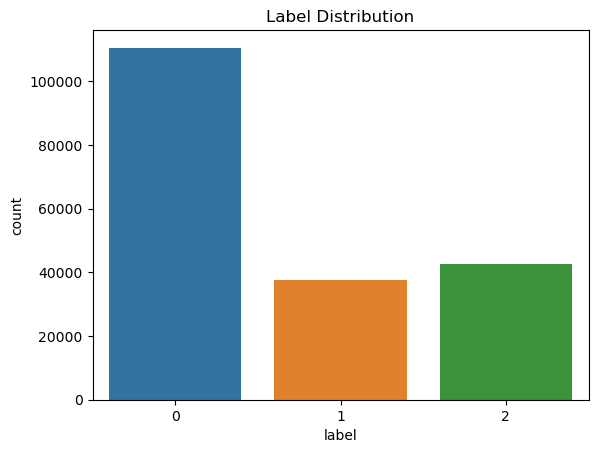

In [5]:
ax = sns.countplot(x='label', data=train_df)
ax.set_title("Label Distribution")

- 다음은 학습 과정에서 데이터의 전처리와 배치 단위 입력을 수월하게 처리해줄 수 있게 하는 DataLoader를 이용하여 모델 학습을 위한 데이터를 전처리하는 함수입니다.
- generate_data_loader를 호출하면 입력된 파일 경로에서 파일을 읽어와 적절한 토크나이징을 진행하고 args에 정의되어 있는 크기만큼 배치 단위로 데이터를 제공할 수 있는 iteratable한 DataLoader 객체를 반환하게 됩니다.

In [6]:
def generate_data_loader(file_path, tokenizer, args):
    def get_input_ids(data):
        document_bert = ["[CLS] " + str(s) + " [SEP]" for s in data]
        tokenized_texts = [tokenizer.tokenize(s) for s in tqdm(document_bert, "Tokenizing")]
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts, "Converting tokens to ids")]
        print("Padding sequences...")
        input_ids = pad_sequences(input_ids, maxlen=args.maxlen, dtype='long', truncating='post', padding='post')
        return input_ids

    def get_attention_masks(input_ids):
        attention_masks = []
        for seq in tqdm(input_ids, "Generating attention masks"):
            seq_mask = [float(i > 0) for i in seq]
            attention_masks.append(seq_mask)
        return attention_masks

    def get_data_loader(inputs, masks, labels, batch_size=args.batch):
        data = TensorDataset(torch.tensor(inputs), torch.tensor(masks), torch.tensor(labels))
        sampler = RandomSampler(data) if args.mode == 'train' else SequentialSampler(data)
        data_loader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return data_loader

    data_df = pd.read_csv(file_path)
    input_ids = get_input_ids(data_df['text'].values)
    attention_masks = get_attention_masks(input_ids)
    data_loader = get_data_loader(input_ids, attention_masks, data_df['label'].values if args.mode=='train' else [-1]*len(data_df))

    return data_loader

- 아래 함수는 모델을 학습/추론하는 과정에서 필요한 보조 함수들입니다.
- save는 torch 라이브러리의 state_dict를 저장하는 기능을 이용해 모델의 가중치만 주어진 경로에 저장하는 함수입니다.
- flat_accuracy는 모델이 예측한 결과값과 정답 라벨을 비교하여 얼마나 정확하게 맞혔는지 정확도를 구해주는 함수입니다.

In [7]:
def save(model, dir_name):
    os.makedirs(dir_name, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(dir_name, 'model.pth'))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

- predict는 학습된 모델을 평가하기 위한 함수입니다. 데이터 입력을 DataLoader 형식으로 받아 모델이 예측한 값을 받아온 뒤 flat_accuracy를 호출하여 정답 라벨과 비교한 정확도를 계산합니다.
- 모델의 추론 과정(Validation 또는 Test 과정)에서 back propagation은 일어나지 않기 때문에, 계산 속도를 높이기 위해 torch.no_grad()를 실행하여 모델에 데이터를 입력해도 gradient가 따로 계산되어 저장되지 않도록 했습니다.

In [8]:
def predict(model, args, data_loader):
    print('start predict')
    model.eval()

    eval_accuracy = []
    logits = []

    for step, batch in tqdm(enumerate(data_loader)):
        batch = tuple(t.to(args.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask)
        logit = outputs[0]

        logit = logit.detach().cpu().numpy()
        label = b_labels.cpu().numpy()

        logits.append(logit)

        accuracy = flat_accuracy(logit, label)
        eval_accuracy.append(accuracy)

    logits = np.vstack(logits)
    predict_labels = np.argmax(logits, axis=1)
    return predict_labels, np.mean(eval_accuracy)

- 이 노트북에서 가장 중요한 부분인 train은 모델을 학습시키기 위한 함수입니다. Train data와 Valid data를 각각 DataLoader 형태로 입력받아 학습과 검증 과정을 거치게 됩니다.
- 개선된 optimization 알고리즘인 AdamW와 learning rate를 선형적으로 감소시키는 linear scheduler를 이용하여 학습을 진행합니다.
- 한 epoch가 종료되면 valid_loader를 이용해 predict를 호출하여 validation accuracy를 계산합니다.
- 대부분의 PyTorch를 활용한 모델 학습 과정은 이 함수와 비슷한 과정을 거쳐 진행되니 패턴에 익숙해지면 좋습니다.

In [9]:
def train(model, args, train_loader, valid_loader):
    optimizer = AdamW(model.parameters(),
                      lr=args.lr,
                      eps=args.eps
                      )
    total_steps = len(train_loader) * args.epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)

    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    print('start training')
    for epoch in range(args.epochs):
        model.train()
        train_loss = []
        for step, batch in tqdm(enumerate(train_loader), f"training epoch {epoch}", total=len(train_loader)):
            model.zero_grad()
            batch = tuple(t.to(args.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = outputs[0]
            train_loss.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = np.mean(train_loss)
        _, avg_train_accuracy = predict(model, args, train_loader)
        _, avg_val_accuracy = predict(model, args, valid_loader)
        print("Epoch {0},  Average training loss: {1:.4f} , Train accuracy : {2:.4f}, Validation accuracy : {3:.4f}"\
              .format(epoch, avg_train_loss, avg_train_accuracy, avg_val_accuracy))

        save(model, "./saved_checkpoints/" + str(epoch))
    return model

- 필요한 함수를 정의 완료했으니 학습을 본격적으로 진행해 봅시다.
- args에는 학습 과정에서 지정해야 할 각종 하이퍼파라미터(배치 사이즈, learning rate 등등)와 데이터 파일 경로 등을 입력해둬 코드 실행 과정에서 사용할 수 있도록 합니다.

In [10]:
args = easydict.EasyDict({
  "train_path" : path+"train.csv",
  "valid_path" : path+"valid.csv",
  "device" : 'cpu',
  "mode" : "train",
  "batch" : 128,
  "maxlen" : 128,
  "lr" : 5e-4,
  "eps" : 1e-6,
  "epochs" : 5,
  "model_ckpt" : MODEL_NAME
})

if torch.cuda.is_available():
    args.device = 'cuda'

- Train/Valid 데이터는 각각 idx, text, label 세 개의 column을 가지는 csv 파일 형태로 이루어져 있습니다. text는 평가 대상 발화 텍스트가, label은 방언 여부를 나타내는 정수 라벨입니다(표준어일 경우 0, 경상도 방언일 경우 1, 제주도 방언일 경우 2).

- 이제 학습을 위한 모델을 준비해 보겠습니다.
- args에 정의되어 있는 모델의 체크포인트를 이용해 Huggingface hub로부터 sequence classification을 위한 모델과 토크나이저를 불러온 뒤, 모델을 GPU 메모리로 옮깁니다.
- 분류해야 하는 class의 종류가 3가지(표준어, 경상도, 제주도)이기 때문에, num_labels를 3으로 지정해 주었습니다.

In [11]:
# load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(args.model_ckpt, num_labels=3)
model.to(args.device)
tokenizer = AutoTokenizer.from_pretrained(args.model_ckpt)

Some weights of the model checkpoint at monologg/koelectra-small-v2-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v2-discriminator and are newly initialized

- 미리 정의된 generate_data_loader 함수를 이용해 train/valid 데이터에 대한 DataLoader를 생성합니다.

In [12]:
train_dataloader = generate_data_loader(args.train_path, tokenizer, args)
validation_dataloader = generate_data_loader(args.valid_path, tokenizer, args)

Converting tokens to ids: 100%|██████████| 190740/190740 [00:02<00:00, 64767.62it/s]


Padding sequences...


Converting tokens to ids: 100%|██████████| 973/973 [00:00<00:00, 75916.77it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 12471.98it/s]


- 모델과 하이퍼파라미터 그리고 데이터가 준비되었으니 학습을 진행시켜 봅시다.
- 각 epoch가 끝날 때 마다 모델의 가중치를 저장하고 validation 결과를 출력합니다. 이를 바탕으로 최적의 결과를 가지는 모델을 선택할 수 있습니다.

In [13]:
model = train(model, args, train_dataloader, validation_dataloader)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


start training


training epoch 0: 100%|██████████| 1491/1491 [06:11<00:00,  4.02it/s]


start predict


1491it [01:51, 13.35it/s]


start predict


8it [00:00, 14.04it/s]


Epoch 0,  Average training loss: 0.3664 , Train accuracy : 0.9081, Validation accuracy : 0.8939


training epoch 1: 100%|██████████| 1491/1491 [06:09<00:00,  4.04it/s]


start predict


1491it [01:51, 13.38it/s]


start predict


8it [00:00, 14.05it/s]


Epoch 1,  Average training loss: 0.2706 , Train accuracy : 0.9245, Validation accuracy : 0.8939


training epoch 2: 100%|██████████| 1491/1491 [06:08<00:00,  4.04it/s]


start predict


1491it [01:51, 13.39it/s]


start predict


8it [00:00, 14.06it/s]


Epoch 2,  Average training loss: 0.2249 , Train accuracy : 0.9409, Validation accuracy : 0.8998


training epoch 3: 100%|██████████| 1491/1491 [06:08<00:00,  4.04it/s]


start predict


1491it [01:51, 13.39it/s]


start predict


8it [00:00, 14.06it/s]


Epoch 3,  Average training loss: 0.1824 , Train accuracy : 0.9563, Validation accuracy : 0.9033


training epoch 4: 100%|██████████| 1491/1491 [06:09<00:00,  4.04it/s]


start predict


1491it [01:51, 13.37it/s]


start predict


8it [00:00, 14.03it/s]


Epoch 4,  Average training loss: 0.1400 , Train accuracy : 0.9668, Validation accuracy : 0.9086


- 학습이 완료된 모델을 활용하여 test 데이터셋에 대한 추론을 진행해 보겠습니다.
- 평가를 위해서는 데이터의 각 인덱스에 맞춰 라벨을 예측하는 것이 필요하기 때문에, 새로운 argument를 정의해 사용하겠습니다.

In [14]:
test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 128,
  "maxlen" : 128,
})

if torch.cuda.is_available():
    test_args.device = 'cuda'

test_dataloader = generate_data_loader(path+"test.csv", tokenizer=tokenizer, args=test_args)
labels, _ = predict(model, test_args, test_dataloader)

Converting tokens to ids: 100%|██████████| 626/626 [00:00<00:00, 57804.07it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 626/626 [00:00<00:00, 5486.22it/s]


start predict


5it [00:00, 13.49it/s]


- 추론 결과는 데이터의 인덱스와 합쳐 제출 파일 형식에 맞게 저장합니다.
- kaggle competition 페이지에서 submit prediction 메뉴를 활용해 예측 결과에 대한 평가를 확인할 수 있습니다.

In [15]:
submit_df = pd.DataFrame()
submit_df["idx"] = range(len(labels))
submit_df["label"] = labels
submit_df.to_csv("submission.csv", index=False)

Text(0.5, 1.0, 'Label Distribution')

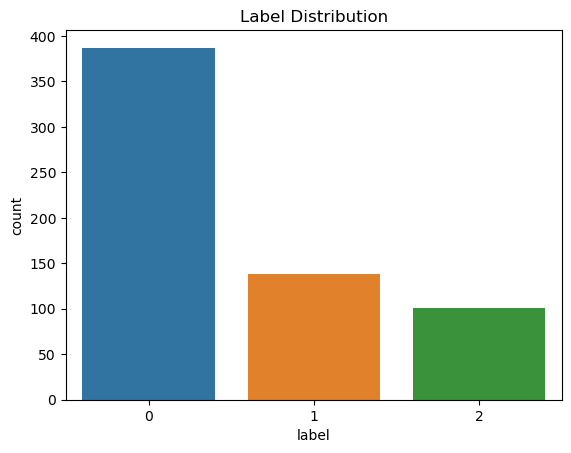

In [16]:
ax = sns.countplot(x='label', data=submit_df)
ax.set_title("Label Distribution")